In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mai 30

@author: yaning
"""

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
from scipy.ndimage import rotate

2025-09-19 17:05:06.264672: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-19 17:05:06.300675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 17:05:07.176453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [3]:
# pick some numbers, rotate and train 1, for different number 2
one = x_train[23]
two = x_train[25]

In [4]:
y_train[25]

np.uint8(2)

In [5]:
one.shape

(28, 28, 1)

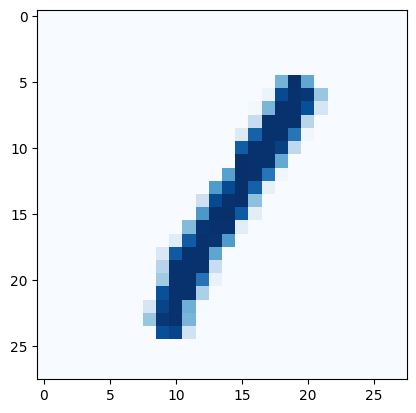

In [6]:
plt.imshow(one, cmap='Blues')

In [7]:
rotate_dataset = []
for i in range(10):
    rotate_dataset.append(rotate(two, i*10, reshape=False))

In [8]:
rotate_dataset = np.array(rotate_dataset)

In [9]:
rotate_dataset.shape

(10, 28, 28, 1)

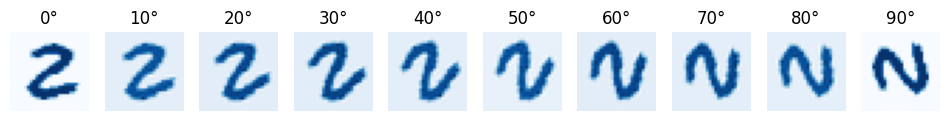

In [20]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(rotate_dataset[i], cmap='Blues')
    plt.title(f"{int(10*i)}°")
    plt.axis('off')
plt.show()

normalise them independently and also keep the 0/pure-black ones zeros

if not the zeros will be around 0.5 after normalisation but there should be no information at all

In [21]:
# only normalise non-zero ones 
def normalise_non_zero(feature_maps):
    data_norm = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[0]):
        img = feature_maps[i]
        non_zero_mask = img != 0
        img = img[non_zero_mask]
        img_min = img.min()
        img_max = img.max()
        if img_max > img_min:
            data_norm[i][non_zero_mask] = (img - img_min) / (img_max - img_min)
        else:
            data_norm[i] = 0
    return data_norm

# normalise everything
def normalise(feature_maps):
    data_norm = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[0]):
        img = feature_maps[i]
        img_min = img.min()
        img_max = img.max()
        if img_max > img_min:
            data_norm[i] = (img - img_min) / (img_max - img_min)
        else:
            data_norm[i] = 0
    return data_norm

In [22]:
# size=7, sigma=2.0, Lambda=3.0, psi=0, gamma=0.5, theta=0
def gabor_kernel(size=4, sigma=4.0, Lambda=10.0, psi=0.5, gamma=1, theta=0):
    """Generate a 2D Gabor filter kernel."""
    half = size // 2
    y, x = np.meshgrid(range(-half, half+1), range(-half, half+1))
    x_theta = x * np.cos(theta) + y * np.sin(theta) + 1
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-0.5 * (x_theta**2 + (gamma**2) * y_theta**2) / (sigma**2)) * np.cos(2 * np.pi * x_theta / Lambda + psi)
    return gb

# Generate 6 filters rotated from 0 to 360
angles = np.deg2rad(np.arange(0, 360, 45))
filters = np.stack([gabor_kernel(theta=angle) for angle in angles], axis=-1)  # shape (size, size, 6)

# Conv2D weights shape: (kernel_h, kernel_w, input_channels, output_channels)
filters = filters[:, :, np.newaxis, :]  # add input channel dim = 1

# Normalize filters to zero mean and unit norm (optional)
filters -= filters.mean(axis=(0,1), keepdims=True)
filters /= np.linalg.norm(filters, axis=(0,1), keepdims=True) + 1e-10

In [23]:
gabor_data = []
for pic in rotate_dataset:
    img = np.expand_dims(pic, axis=0)
    feature_maps = tf.nn.conv2d(img, filters, strides=3, padding='SAME')
    gabor_data.append(feature_maps[0])

In [14]:
gabor_data = []
img = np.expand_dims(two, axis=0)
feature_maps = tf.nn.conv2d(img, filters, strides=3, padding='SAME')
gabor_data.append(feature_maps[0])

In [25]:
gabor_data = np.array(gabor_data)

In [26]:
gabor_data.shape

(10, 10, 10, 8)

In [46]:
normalised_gabor_data = normalise_non_zero(gabor_data)

In [47]:
normalised_gabor_data.shape

(10, 10, 10, 8)

In [44]:
normalised_gabor_data = np.where(normalised_gabor_data > 0.5, 1, 0)

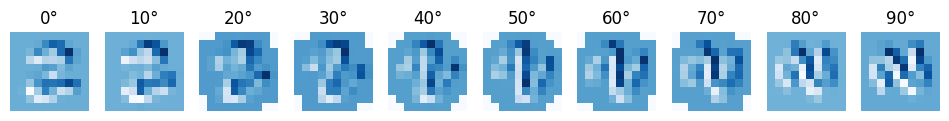

In [48]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(normalised_gabor_data[i, :, :, 3], cmap='Blues')
    plt.title(f"{int(10*i)}°")
    plt.axis('off')
plt.show()

In [17]:
import pickle
path = "/home/yaning/Documents/"

with open(path + "gabor_data_10p_8f_two.pkl", "wb") as f:
    pickle.dump(normalised_gabor_data, f)